# SIMPLE LSTM MODEL
PyTorch model to predict 3-dimensional time series

Uses Simulated Data.


# Data preparation


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [ ]:
class SimData:
    def __init__(self,n=300,autocorr=0.15,prob_train=0.8,n_history=8,n_steps_out=4,seed=25):
        self.n_train = int(n*prob_train)
        self.n_test = n - self.n_train
        self.n_history = n_history
        self.n_steps_out = n_steps_out
        self.simulate_data(n,autocorr,seed)

    def simulate_data(self, n, autocorr, seed):
        mult = torch.tensor([[0,1,0.5],[1,0,0.5],[0.5,1,1]])
        static_vect = torch.tensor([0.4,-0.2,0.0])
        vecs = [static_vect]
        torch.manual_seed(seed)

        for i in range(n-1):
            vecs.append(
                autocorr*torch.matmul(vecs[-1],mult) + \
                0.05*torch.randn(static_vect.size(0)) +
                (1.0-autocorr)*static_vect
                )
        self.data = torch.tensor(np.array(vecs), dtype=torch.float32)

    def get_train_test(self):
        return (
            self.data[:self.n_train+self.n_steps_out],
            self.data[self.n_train-self.n_history:]
            )


class TimeSeriesDataset(TensorDataset):
    def __init__(self, data, n_history=8, n_steps_out=4):
        self.data = data
        self.n_history = n_history
        self.n_steps_out = n_steps_out

    def __len__(self):
        return len(self.data) - self.n_history - self.n_steps_out + 1

    def __getitem__(self, t):
        idx = t + self.n_history
        input_sequence = self.data[idx-self.n_history:idx]
        target = self.data[idx:idx+self.n_steps_out]
        return input_sequence, target

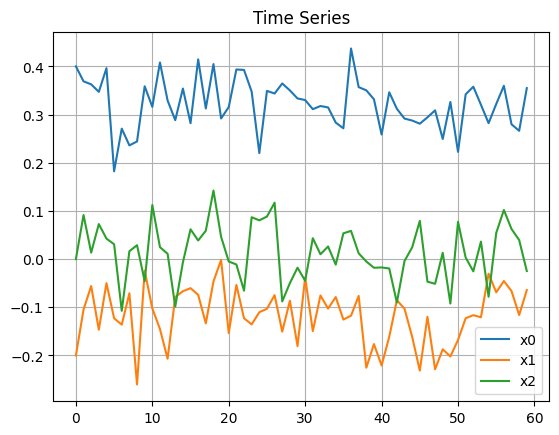

In [ ]:
simdat = SimData()
X_train, X_valid = simdat.get_train_test()
pd.DataFrame(X_train.numpy(),columns=[f'x{i}' for i in range(simdat.data.size(1))]).iloc[:60].plot(title='Time Series',grid=True);

In [ ]:
trainloader = DataLoader(TimeSeriesDataset(X_train), batch_size=8, shuffle=True)
validloader = DataLoader(TimeSeriesDataset(X_valid), batch_size=8, shuffle=True)

# Multivariate LSTM Network

In [ ]:
class LSTMModel(torch.nn.Module):
    def __init__(self, xdim, n_steps_out, hidden_dim=32, layer_dim=2):
        super().__init__()
        self.xdim = xdim
        self.hidden_dim = hidden_dim
        self.n_steps_out = n_steps_out
        self.layer_dim = layer_dim
        self.lstm = torch.nn.LSTM(xdim, hidden_dim, layer_dim, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_dim, n_steps_out*xdim)

    def forward(self, x, h0=None, c0=None):
        batch_size, seq_len, _ = x.size()

        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        cn = cn.view(self.layer_dim, batch_size, self.hidden_dim)
        x = cn[-1]
        x = self.relu(x)
        x = self.fc(x)
        x = x.view(batch_size, self.n_steps_out, self.xdim)
        return x

# Training

In [ ]:
model=LSTMModel(simdat.data.size(1),simdat.n_steps_out)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    nloss = 10

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % nloss == nloss-1:
            last_loss = running_loss / nloss # loss per batch
            print('  batch {:02d} loss: {:.4f}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(trainloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 4

best_vloss = 1_000_000.
losses = []

for epoch in tqdm(range(EPOCHS),
    bar_format='[{elapsed}<{remaining}] {n_fmt}/{total_fmt} | {l_bar}{bar} {rate_fmt}{postfix}',
    colour='yellow',leave=False):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    losses.append(avg_vloss.item())
    print('LOSS train {:.4f} valid {:.4f}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

print("\nBest Validation Loss: {:.4f}".format(best_vloss.item()))

[00:00<?] 0/4 |   0%|           ?it/s

EPOCH 1:
  batch 10 loss: 1.8361
  batch 20 loss: 0.0541
  batch 30 loss: 0.0261
LOSS train 0.0261 valid 0.0200
EPOCH 2:
  batch 10 loss: 0.0067
  batch 20 loss: 0.0037
  batch 30 loss: 0.0030
LOSS train 0.0030 valid 0.0025
EPOCH 3:
  batch 10 loss: 0.0032
  batch 20 loss: 0.0031
  batch 30 loss: 0.0027
LOSS train 0.0027 valid 0.0024
EPOCH 4:
  batch 10 loss: 0.0029
  batch 20 loss: 0.0031
  batch 30 loss: 0.0032
LOSS train 0.0032 valid 0.0027

Best Validation Loss: 0.0024


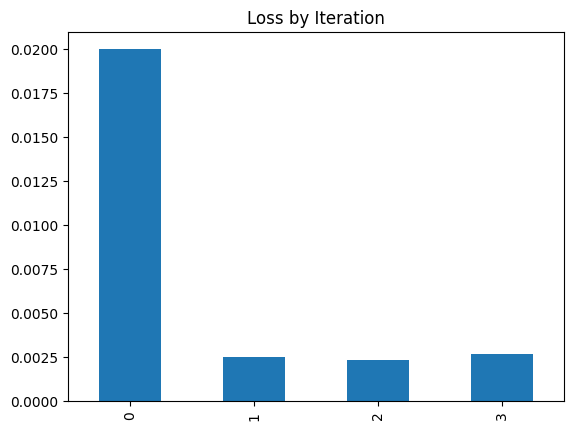

In [ ]:
pd.Series(losses,name='loss').plot.bar(title="Loss by Iteration");

# Visualize Results

Use saved model.

In [ ]:
saved_model = LSTMModel(simdat.data.size(1),simdat.n_steps_out)
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
p_iter = iter(validloader)
for _ in range(3):
    next(p_iter)
inputs, labels = next(p_iter)

In [ ]:
t_pre = range(len(inputs[0]))
t_post = [len(inputs[0])+t for t in range(len(labels[0]))]
df_in = pd.DataFrame(inputs[0].numpy(),columns=[f'x{i}' for i in range(simdat.data.size(1))],index=t_pre)
df_out = pd.DataFrame(labels[0].numpy(),columns=[f'y{i}' for i in range(simdat.data.size(1))],index=t_post)
df_pred = pd.DataFrame(saved_model(inputs)[0].detach().numpy(),columns=[f'y_pred{i}' for i in range(simdat.data.size(1))],index=t_post)

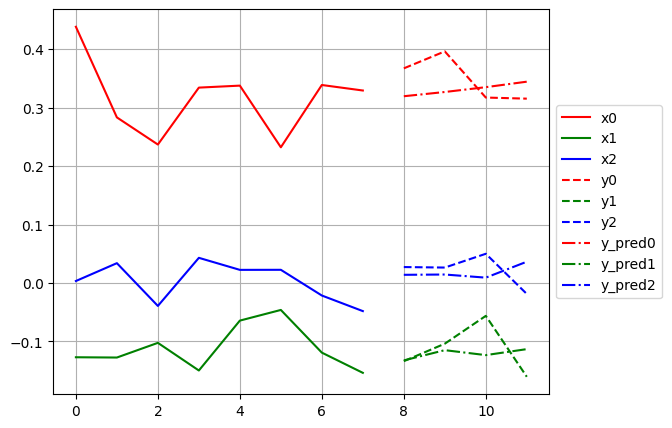

In [ ]:
linestyle = ["-"]*3 + ["--"]*3 + ["-."]*3
dcolor = ['red','green','blue']*3
ax = pd.concat([df_in,df_out,df_pred],axis=1).plot(
    grid=True,figsize=(8, 5),style=linestyle,color=dcolor);

# Get current position and shrink the plot to make space for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink width by 20%

# Place the legend outside the plot, to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
